# Exact Quantum Simulation for XY model

Meng Hua

Mentor:Alba

# Introduction


### Installing necessary packages

In this notebook we will use [Tequila](https://github.com/aspuru-guzik-group/tequila), an Extensible Quantum Information and Learning Architecture, with [Qiskit](https://qiskit.org/) backends:

In [2]:
# Run this cell for packages' installation. The outputs will be cleared at the end.
!pip install qiskit
!pip install matplotlib
!pip install git+https://github.com/aspuru-guzik-group/tequila.git
    
from IPython.display import clear_output
clear_output()

import tequila as tq
import numpy as np
from numpy import pi
import qiskit

# 1.Theory 

## The XY model
The $XY$ model is a generalization of 1D Ising and is also the simplest non-trivial integrable model. When we use exact quantum simulation on the many-body physics model, we will be able to access the states in the whole spectrum rather than only ground states. 

The Hamiltonian of XY model can be written as:
$$H_{XY}=\sum_{i=1}^n(\frac{1+\gamma}{2}\sigma_i^x\sigma_{i+1}^x+\frac{1-\gamma}{2}\sigma_i^y\sigma_{i+1}^y)+\lambda\sum_{i=1}^n\sigma_i^z+\frac{1+\gamma}{2}\sigma_1^y\sigma_2^z...\sigma_{n-1}^z\sigma_n^y+\frac{1-\gamma}{2}\sigma_1^x\sigma_2^z...\sigma_{n-1}^z\sigma_n^x$$

It describes an anisotropic nearest-neighbor spin-spin interaction in $XY$-plane with a external magnetic field $\lambda$ along $z$ direction. The last two terms are introduced to give the correct boundary condition when transform the model to Fermionic basis. They will be surpressed as $n\rightarrow\infty$.

This model can be reduced to two unversality class. For $\gamma = 0$ the model is isotropic in $xy$-plane with central charge $c=1$. For $\gamma = 1$ the model becomes Ising model with central charge $c=1/2$.

## The exact solution and quantum circuit implementation for XY model

The idea of quantum simulation is that we impose the interaction of target quantum system to a set of unentangled qubits and these qubits will simulate the target quantum system. In this notebook, the target quantum system is the XY model, the unentagled qubits sit at the begining of a quantum circuit and we impose the interaction by applying a series of quantum gates.

In another words, we want to create a quantum circuit $U_{dis}$ which can diagonalize the Hamiltonian as an unitarty transformation such that $$H_{XY} =U_{dis}\tilde{H}U_{dis}^\dagger $$.

Using this circuit, we can 
1. start from a eigenstate(product state) of the non-interaction Hamiltonian $\tilde{H}$ to create the excited eigenstates of $H_{XY}$
2. simulate time evolution of a state
3. simulate thermal state $exp(-\beta H_{XY})$

In this notebook, we will show how to use simulators in Tequila as well as the real ibmQ device to do the first two and leave thermal state simulation for future discussion.

The quantum circuit $U_{dis}$ consists with three basis transformations: A Jordan-Wigner transformatiom that transforms spins into fermions, a Fourier transformation that transform from real space into momentum space and a Bogoliubov transformation to decouple the positive and negative modes. We will show how to write those transformations as quantum gates and how to implement them using Tequila.

<img src = circuit.png style = "width : 650px">


## Jordan-Wigner transformation

Many-body physics need to handle models with quantum spins, however, they are very difficult to deal with. Jordan and Wigner found that a single spin can be represented by a fermion, with up and down spins corresponding to empty and occupied fermion states respectively. However, different spins commute but different fermions anticommute. So we can dress the spin ladder operators $\sigma^{+/-}=\frac{(\sigma^x+i\sigma^y)}{2}$ with some operators to the satisfy commutation relation[[1]](http://tqm.courses.phy.cam.ac.uk/docs/lectures/JordanWigner/).

$$c_j = \overbrace{\sigma^z\otimes ...\otimes\sigma^z}^{j-1}\otimes\frac{\sigma^x-i\sigma^y}{2}\otimes\overbrace{\mathbb{1}\otimes ...\otimes\mathbb{1}}^{N-j \text{ times}}=(\prod_{k=1}^{j-1}{\sigma^z_k})\sigma_j^-$$

$$c_j^\dagger = \overbrace{\sigma^z\otimes ...\otimes\sigma^z}^{j-1}\otimes\frac{\sigma^x+i\sigma^y}{2}\otimes\overbrace{\mathbb{1}\otimes ...\otimes\mathbb{1}}^{N-j \text{ times}}=(\prod_{k=1}^{j-1}{\sigma^z_k})\sigma_j^+$$

It is obvious that for fermions at two sites $i$ and $j$ where $i\neq j$, the only anticommuting part should be $$\{\frac{\sigma_i^x-i\sigma_i^y}{2},\sigma_j^z\}=0.$$

So for the fermion operators $c_j$ we have:
$$\{c_i,c_j\}=0,\quad \{c_i,c_j^\dagger\}=\delta_{ij}$$

Notice that $\sigma^z_j$ is just counting the number of fermions at site $j$, if site $j$ is unoccupied $<\sigma^z> = -1$, otherwise $<\sigma^z>=+1$ and site $j$ is occupied, so we have:
$$\sigma^z_j=2c_j^\dagger c-1 = 2n_j-1=\begin{cases}
    -1,& \text{if site $j$ is unoccupied} \\
    +1,              & \text{if site $j$ is occupied}
\end{cases} = -exp(-i\pi n_j)$$

Because $$\sigma^+_j=(\prod_{k=1}^{j-1}{\sigma^z_k})c_j^+=exp(-i\sum_{k=1}^{j-1}n_k)c_j^+$$

In [4]:
tq.show_available_simulators()

backend         | wfn        | sampling   | noise      | installed 
--------------------------------------------------------------------
qulacs_gpu      | False      | False      | False      | False     
qulacs          | True       | True       | True       | True      
qibo            | False      | False      | False      | False     
qiskit          | True       | True       | True       | True      
cirq            | True       | True       | True       | True      
pyquil          | False      | False      | False      | False     
symbolic        | True       | False      | False      | True      


(In Teaqulia we can compile the circuit into object with different backend. )

In [5]:
def fSWAP(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + tq.gates.CNOT(q1,q0) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.CZ(q0,q1)
    return circuit
    
    
qiskit_fswap = tq.compile(fSWAP(0,1),backend = 'qiskit')
qiskit_fswap.circuit.draw()

┌───┐        
q_0: ──■──┤ X ├──■───■─
     ┌─┴─┐└─┬─┘┌─┴─┐ │ 
q_1: ┤ X ├──■──┤ X ├─■─
     └───┘     └───┘   
c: 2/══════════════════

In [6]:
# CH (Controlled-Haddamard)
# control qubit: q1
# target qubit: q0
def CH2(q0,q1):
    circuit = tq.gates.Phase(phi=-pi/2,target=q0) + tq.gates.H(q0) + tq.gates.Phase(phi=-pi/4,target=q0)
    circuit += tq.gates.H(q0) + tq.gates.H(q1) + tq.gates.CNOT(q0,q1) + tq.gates.H(q0) +tq.gates.H(q1)
    circuit += tq.gates.T(q0) + tq.gates.H(q0) + tq.gates.S(q0)
    return circuit
qiskit_mix = tq.compile(CH2(0,1),backend = 'qiskit')
# Fourier transform gates

def F2(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + CH2(q0,q1) + tq.gates.CNOT(q0,q1) +tq.gates.CZ(q0,q1)
    return circuit

def F0(q0,q1):
    return F2(q0,q1)
    
def F1(q0,q1):
    return F2(q0,q1) + tq.gates.Phase(phi=-pi/2,target=q0)


Bogoliubov transformation

In [7]:
from math import pi

# control qubit: q0
# target qubit: q1
def CRX(theta, q0, q1):
    circuit = tq.gates.Rz(angle=pi/2.0,target=q1) + tq.gates.Ry(angle=theta, target=q1) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.Ry(angle=-pi/2.0,target=q1) + tq.gates.CNOT(q0,q1) + tq.gates.Rz(angle=-pi/2.0,target=q1)
    return circuit

def B(theta_k,q0,q1):
#     circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +CRX(theta_k,q0,q1) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)
    circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +tq.gates.CRx(control=q0,target=q1,angle=theta_k) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)

    return circuit

For XY model, the quantum circuit will depends on another parameter: $\gamma$. Only Bogoliubov transformation will be different.

$$\theta_k=2\arctan(\frac{J\gamma\sin(2\pi k/n)}{J\cos(2\pi k/n)+\lambda})$$

or use PRA convention:

$$\theta_k=\arccos(\frac{-\lambda+\cos(2\pi k/n)}{\sqrt{(\lambda-\cos(2\pi k/n))^2+\gamma^2\sin^2(2\pi k /n)}})$$

where $J=1, k=1,n=4$

In [8]:
def Udisg(lam,gamma,q0,q1,q2,q3):
    k=1
    n=4
#     th1=-np.arccos((lam-np.cos(2*pi*k/n))/np.sqrt((lam-np.cos(2*pi*k/n))**2+np.sin(2*pi*k/n)**2))
#     th1 = 2*np.arctan( (gamma*np.sin( 2*pi*k/n )) / (np.cos( 2*pi*k/n ) + lam ))
    th1 = -np.arccos((lam-np.cos(2*pi*k/n))/np.sqrt((lam-np.cos(2*pi*k/n))**2+gamma**2 * np.sin(2*pi*k/n)**2))
    circuit = B(th1,q0,q1)+ F1(q0,q1) + F0(q2,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    circuit += F0(q0,q2)
    circuit += F0(q1,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    return circuit

def XYmodel(lam,gamma,q0,q1,q2,q3):
    if lam<1:
        return tq.gates.X(q3) + Udisg(lam,gamma,q0,q1,q2,q3)
    else:
        return Udisg(lam,gamma,q0,q1,q2,q3)

# 2. Simulation

In [9]:
# simulation
def sim_run_expecM(lam,gamma):
    shots = 1024
    H = tq.paulis.Z([1])
    
    circuit = XYmodel(lam,gamma,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',samples=shots)
    return M

In [10]:
#Real Device
def real_device_run_expecM(real_device, lam,gamma):
    shots = 1024
    H = tq.paulis.Z([1])
    circuit = XYmodel(lam,gamma,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',device = real_device,samples=shots)
    return M

In [39]:
from qiskit import IBMQ
MY_IBMQ_TOKEN='55dee9b655b84737468de95877d2c72ecf8d7fc6b40cf6edb2b96668fbe80b40381e0f216fd0ab70a256ac97ad4030cef9ab39f3aae616720069fa2c5b9a111c'
IBMQ.save_account(MY_IBMQ_TOKEN, overwrite=True) # needs to be done once, and is then saved in our environment
IBMQ.load_account()
# see the list of backends that you can use:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
print(provider.backends())

ibmqfactory.load_account:WARNING:2021-01-21 01:20:41,311: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [41]:
real_device_run_expecM('ibmq_vigo', 0.2, 1)

0.1875

In [21]:
vigo_output = [real_device_run_expecM('ibmq_vigo', 0.2*i, 1) for i in range(10)]

In [18]:
mag_sim = [sim_run_expecM(0.2*i,1) for i in range(10)]

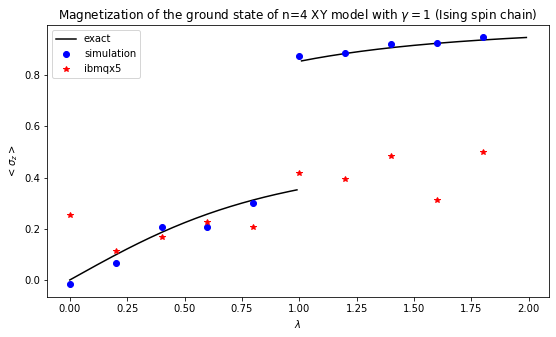

In [23]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
def exact(lam):
    if lam <1:
        return lam/(2*np.sqrt(1+lam**2))
    if lam >1:
        return 1/2+lam/(2*np.sqrt(1+lam**2))
    return None
vexact = np.vectorize(exact)
l=np.arange(0.0,2.0,0.01)
l1=np.arange(0.0,2.0,0.2)
plt.figure(figsize=(9,5))
plt.plot(l,vexact(l),'k',label='exact')
plt.plot(l1, mag_sim, 'bo',label='simulation')
plt.plot(l1, vigo_output, 'r*',label='ibmqx5')
plt.xlabel('$\lambda$')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Magnetization of the ground state of n=4 XY model with $\gamma = 1$ (Ising spin chain)')
plt.show()


### Time Evolution of $|\uparrow>^{\otimes4}=|0>^{\otimes 4}$ (in $H_{XY}$ basis)

First find the corresponding state in the diagonal basis ($\tilde{H}$)

$$|\tilde{\psi}_0>=U_{dis}^{\dagger}|0000>=\cos{\phi}|0000>+i\sin{\phi}|1100>$$
$$\phi = \frac{1}{2}\arccos{\frac{-\lambda+\cos{\frac{2\pi k}{n}} }{\sqrt{(\lambda-\cos{\frac{2\pi k}{n} })^2 +\gamma^2\sin^2{\frac{2\pi k}{n}}}}}$$

For Ising model $\gamma =1,k=1,n=4$,$$\phi = \frac{1}{2}\arccos(\frac{\lambda}{\sqrt{1+\lambda^2}})$$

The time evolution of $|\tilde{\psi}(t)> = e^{-itE_i}$

$$|\tilde{\psi}(t)> =(\cos\phi|00>+ie^{4it\sqrt{1+\lambda^2}}\sin\phi|11>)\otimes|00>$$

We impelement this state using $R_y(2\phi)=e^{-i\phi\sigma_y} = \cos\phi-i\sigma_y\sin\phi=\begin{pmatrix}
\cos\phi & -\sin\phi \\
\sin\phi & \cos\phi 
\end{pmatrix}$ and also a phase gate for the phase $-ie^{4it\sqrt{1+\lambda^2}}$

In [28]:
import numpy as np
def Initial_time(t,lam,q0,q1,q2,q3):
    circuit = tq.gates.Ry(np.arccos(lam/np.sqrt(1+lam**2)),q0)+tq.gates.Phase(3*pi/2+4*t*np.sqrt(1+lam**2),q0)
    circuit += tq.gates.CNOT(q0,q1)
    return circuit

def Ising_time(t,lam,gamma,q0,q1,q2,q3):
#     if lam<1:
#         return tq.gates.X(q3) + Initial_time(t,lam,q0,q1,q2,q3) + Udisg(lam,q0,q1,q2,q3)
#     else:
    return Initial_time(t,lam,q0,q1,q2,q3) + Udisg(lam,gamma,q0,q1,q2,q3)

In [46]:
def real_time_evo_M(real_device,lam,time,gamma):
    shots = 1024
    H = tq.paulis.Z([1])

    circuit = Ising_time(time,lam,gamma,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',device=real_device,samples=shots)
    return M

def sim_time_evo_expecM(lam,time,gamma):
    shots = 1024
    H = tq.paulis.Z([1])

    circuit = Ising_time(time,lam,gamma,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',samples=shots)
    return M

In [47]:
magt_sim = [[sim_time_evo_expecM(lam,i*0.25,1) for i in range(9)] for lam in [0.5,0.9,1.8]]

In [48]:
print(magt_sim)

[[1.0, 0.78125, 0.345703125, 0.22265625, 0.50390625, 0.8984375, 0.95703125, 0.595703125, 0.263671875], [1.0, 0.787109375, 0.46484375, 0.546875, 0.896484375, 0.96875, 0.69140625, 0.427734375, 0.63671875], [1.0, 0.8203125, 0.833984375, 0.994140625, 0.8515625, 0.783203125, 0.994140625, 0.85546875, 0.802734375]]


In [50]:
vigo_time_evo5 = [[real_time_evo_M('ibmq_vigo',lam,i*0.25,1) for i in range(9)] for lam in [0.5,0.9,1.8]]

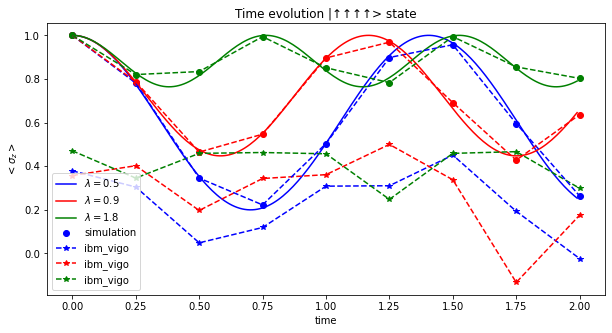

In [51]:

def exact_time(lam,tt):
    Mt=(1 + 2*lam**2 + np.cos(4*tt*np.sqrt(1 + lam**2)))/(2 + 2*lam**2)
    return Mt
vexact_t = np.vectorize(exact_time)
t=np.arange(0.0,2.0,0.01)
tt=np.arange(0.0,2.25,0.25)
plt.figure(figsize=(10,5))
plt.plot(t,vexact_t(0.5,t),'b',label='$\lambda=0.5$')
plt.plot(t,vexact_t(0.9,t),'r',label='$\lambda=0.9$')
plt.plot(t,vexact_t(1.8,t),'g',label='$\lambda=1.8$')
plt.plot(tt, magt_sim[0], 'bo',label='simulation')
plt.plot(tt, magt_sim[1], 'ro')
plt.plot(tt, magt_sim[2], 'go')
plt.plot(tt, vigo_time_evo5[0], 'b*--',label='ibm_vigo')
plt.plot(tt, vigo_time_evo5[1], 'r*--',label='ibm_vigo')
plt.plot(tt, vigo_time_evo5[2], 'g*--',label='ibm_vigo')
plt.plot(tt, magt_sim[0], 'b--')
plt.plot(tt, magt_sim[1], 'r--')
plt.plot(tt, magt_sim[2], 'g--')
plt.xlabel('time')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Time evolution |↑↑↑↑> state')
plt.show()